**Dependencies**

In [323]:
from pathlib import Path
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from category_encoders import CatBoostEncoder

pd.set_option('display.max_columns',None)

**Loading Dataset**

In [324]:
directory = Path().parent.absolute()
filepath = directory / 'Dataset'
raw_training = pd.read_csv(filepath / 'train.csv')
raw_testing = pd.read_csv(filepath / 'test.csv')
raw_training.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46

In [3]:
print('Number of unique galaxies in training: {}'.format(raw_training['galaxy'].nunique()))
print('Frequncy of each galaxy in training data:\n {}'.format(raw_training['galaxy'].value_counts()))

Number of unique galaxies in training: 181
Frequncy of each galaxy in training data:
 Andromeda XIX[60]                              26
Andromeda XXII[57]                             26
Andromeda XXIV                                 26
Tucana Dwarf                                   26
Andromeda XII                                  26
                                               ..
Wolf-Lundmark-Melotte (WLM, DDO 221)           17
Sagittarius Dwarf Irregular Galaxy (SagDIG)    17
Pegasus Dwarf Irregular (DDO 216)              17
Aquarius Dwarf Galaxy (DDO 210)                17
NGC 5253                                        1
Name: galaxy, Length: 181, dtype: int64


In [4]:
print('Number of unique galaxies in testing: {}'.format(raw_testing['galaxy'].nunique()))
print('Frequncy of each galaxy in testing data:\n {}'.format(raw_testing['galaxy'].value_counts()))

Number of unique galaxies in testing: 172
Frequncy of each galaxy in testing data:
 Sagittarius Dwarf Irregular Galaxy (SagDIG)    10
Andromeda X                                    10
Andromeda XXI[57]                              10
Wolf-Lundmark-Melotte (WLM, DDO 221)           10
Aquarius Dwarf Galaxy (DDO 210)                10
                                               ..
Pegasus III                                     1
Boötes IV                                       1
Pisces II                                       1
Leo IV Dwarf                                    1
Canes Venatici II Dwarf                         1
Name: galaxy, Length: 172, dtype: int64


## Preprocessing:

Extract and remove target values from training dataset

In [325]:
training = raw_training.drop('y', axis = 1)
y = raw_training['y']

### Cleaning Outliers

#### Absolute
Columns containing incorrect negative sign values

In [6]:
def absolute(panda, column):
    panda[column] = panda[column].abs()

In [326]:
absolute(training, 'Gross income per capita')
absolute(training, 'Population, total (millions)')
absolute(training, 'Population, ages 15–64 (millions)')
absolute(training, 'Population, ages 65 and older (millions)')
absolute(training, 'Population, under age 5 (millions)')
absolute(training, 'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)')
absolute(training, 'Employment in agriculture (% of total employment)')
absolute(training, 'Gross galactic product (GGP), total')
absolute(training, 'Population, total (millions)')
absolute(training, 'Estimated gross galactic income per capita, female')
absolute(training, 'Intergalactic inbound tourists (thousands)')
absolute(training, 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total')

#### Floor ( Discrete Values )
Columns with values that are supposed to be discrete but are continuous

In [8]:
def Floor(panda, column):
    panda[column] = np.floor(panda[column])

In [327]:
Floor(training, 'Intergalactic Development Index (IDI), Rank')
Floor(training, 'Intergalactic Development Index (IDI), female, Rank')
Floor(training, 'Intergalactic Development Index (IDI), male, Rank')

#### Capping 

In [10]:
def max100(panda, column):
    panda.loc[panda[column] > 100, column ] = 100

In [328]:
max100(training, 'Population using at least basic drinking-water services (%)')
max100(training, 'Population using at least basic sanitation services (%)')
max100(training, 'Population, urban (%)')
max100(training, 'Vulnerable employment (% of total employment)')
max100(training, 'Employment in agriculture (% of total employment)')
max100(training, 'Labour force participation rate (% ages 15 and older)')
max100(training, 'Labour force participation rate (% ages 15 and older), female')
max100(training, 'Employment in services (% of total employment)')
max100(training, 'Labour force participation rate (% ages 15 and older), male')
max100(training, 'Employment to population ratio (% ages 15 and older)')
max100(training, 'Jungle area (% of total land area)')
max100(training, 'Renewable energy consumption (% of total final energy consumption)')
max100(training, 'Estimated gross galactic income per capita, female')
max100(training, 'Population with at least some secondary education, female (% ages 25 and older)')
max100(training, 'Population with at least some secondary education, male (% ages 25 and older)')
max100(training, 'Population with at least some secondary education (% ages 25 and older)')
max100(training, 'Gross enrolment ratio, primary (% of primary under-age population)')
max100(training, 'Interstellar Data Net users, total (% of population)')

### Encoding categorical features
Tried multiple encoders. CatBoost encoder resulted in the best rmse.

In [329]:
encoder = CatBoostEncoder(cols=['galaxy'])
encoder.fit(training, y)
training = encoder.transform(training, y)

In [137]:
training.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
0,990025,0.082773,0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46.018230,98.216072,174.

**Failed Preprocessing trials**
* Imputation of the missing data using the IterativeImputer from fancyimputer (MICE Imputer) resulted in worse rmse than XGBoost's internal handling
* Clustering

## Hyperparamater Tuning

### Cross Validation model

In [26]:
def model(dmatrix, learning_rate = 0.1, max_depth = 3, colsample_bytree = 1, min_child_weight = 1, \
          n_estimators = 1000, subsample = 1, reg_alpha = 0, seed = 1246):
    
    params = {'learning_rate':learning_rate, 'max_depth':max_depth, 'colsample_bytree':colsample_bytree, \
              'min_child_weight':min_child_weight, 'subsample':subsample, 'reg_alpha':reg_alpha}
    
    result = xgb.cv(dtrain = dmatrix, params = params, nfold = 5, num_boost_round= n_estimators, \
                  early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed = seed)
                    
    #Plot training rsme and validation rsme aganist number of estimators
    #if graph:
    #    result.plot(use_index = True, y = ['train-rmse-mean', 'test-rmse-mean'])
        
    # Extract rsme values for training and validation from result data frame
    best_rsme = result.tail(1)
    #print(best_rsme)
    return best_rsme.index[0], best_rsme['train-rmse-mean'].values[0], best_rsme['test-rmse-mean'].values[0]

In [138]:
dmatrix = xgb.DMatrix(data = training, label = y)
rnd = np.random.randint(0,1000)

In [33]:
rnd

192

### Learning Rate and Max Depth

In [32]:
max_depth = [2,3,4,5]
learning_rate = [0.01, 0.02, 0.05, 0.1, 0.12, 0.15, 0.18, 0.2, 0.3]
for lr in learning_rate:
    for md in max_depth:
        n ,train_rmse, validation_rmse = model(dmatrix, learning_rate=lr, max_depth=md, seed = rnd, n_estimators=3000)
        print('Learning Rate {} Max Depth {} n{} Train RMSE {} Validation RMSE {}'.format(lr, md, n, train_rmse, validation_rmse))

Learning Rate 0.01 Max Depth 2 n2999 Train RMSE 0.0055116 Validation RMSE 0.012211799999999998
Learning Rate 0.01 Max Depth 3 n2506 Train RMSE 0.003474 Validation RMSE 0.011072400000000001
Learning Rate 0.01 Max Depth 4 n902 Train RMSE 0.0035168000000000005 Validation RMSE 0.010891
Learning Rate 0.01 Max Depth 5 n1075 Train RMSE 0.0023028 Validation RMSE 0.0114964
Learning Rate 0.02 Max Depth 2 n1739 Train RMSE 0.0049414 Validation RMSE 0.011881800000000001
Learning Rate 0.02 Max Depth 3 n1283 Train RMSE 0.0034014 Validation RMSE 0.0110372
Learning Rate 0.02 Max Depth 4 n1110 Train RMSE 0.0021832 Validation RMSE 0.0106438
Learning Rate 0.02 Max Depth 5 n695 Train RMSE 0.0019936 Validation RMSE 0.0114416
Learning Rate 0.05 Max Depth 2 n887 Train RMSE 0.0042916 Validation RMSE 0.011696600000000001
Learning Rate 0.05 Max Depth 3 n907 Train RMSE 0.0022872 Validation RMSE 0.0108212
Learning Rate 0.05 Max Depth 4 n461 Train RMSE 0.0020938 Validation RMSE 0.0106836
Learning Rate 0.05 Max Dept

**Two observations we can make from this data:**
* There is pattern of getting the lowest rmse using max depth = 3 or 4. need to explore further to find which one is better
* Using Max Depth = 4 we can notice that the rmse was in the 0.010 range when the learning rate was below 0.12 and it was in the 0.011 range when the learning rate was above that

In [36]:
max_depth = [3,4]
learning_rate = [0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14]
for md in max_depth:
    for lr in learning_rate:   
        n ,train_rmse, validation_rmse = model(dmatrix, learning_rate=lr, max_depth=md, seed = rnd, n_estimators=3000)
        print('Learning Rate {} Max Depth {} n{} Train RMSE {} Validation RMSE {}'.format(lr, md, n, train_rmse, validation_rmse))

Learning Rate 0.01 Max Depth 3 n2506 Train RMSE 0.003474 Validation RMSE 0.011072400000000001
Learning Rate 0.015 Max Depth 3 n1918 Train RMSE 0.0031784 Validation RMSE 0.010966400000000001
Learning Rate 0.02 Max Depth 3 n1283 Train RMSE 0.0034014 Validation RMSE 0.0110372
Learning Rate 0.025 Max Depth 3 n351 Train RMSE 0.0055986 Validation RMSE 0.0116438
Learning Rate 0.03 Max Depth 3 n1173 Train RMSE 0.0027702 Validation RMSE 0.0108848
Learning Rate 0.04 Max Depth 3 n918 Train RMSE 0.0026401999999999997 Validation RMSE 0.010975599999999999
Learning Rate 0.045 Max Depth 3 n172 Train RMSE 0.00583 Validation RMSE 0.0115934
Learning Rate 0.05 Max Depth 3 n907 Train RMSE 0.0022872 Validation RMSE 0.0108212
Learning Rate 0.055 Max Depth 3 n968 Train RMSE 0.0019986 Validation RMSE 0.0107178
Learning Rate 0.06 Max Depth 3 n800 Train RMSE 0.0021469999999999996 Validation RMSE 0.010712
Learning Rate 0.07 Max Depth 3 n470 Train RMSE 0.0028442000000000003 Validation RMSE 0.0108922
Learning Rate 

* It is now clear that the average rmse of max depth = 4 is better.
* Lowest RMSE at learning rate = 0.055

**Learning Rate = 0.055, Max Depth = 4**

### Colsample_bytree and Subsample

In [51]:
Colsample_bytree = [0.6, 0.7, 0.8, 0.9, 1]
Subsample = [0.6, 0.7, 0.8, 0.9, 1]
for csbt in Colsample_bytree:
    for ss in Subsample:
        n, train_rsme, validation_rsme = model(dmatrix, learning_rate=0.055, max_depth=4, colsample_bytree=csbt, \
                                               subsample=ss, n_estimators= 3000, seed = rnd)
        print('CSBT {} SS {}  n{} Train RSME {}, Validation RSME {}'.format(csbt, ss, n, train_rsme, validation_rsme))

CSBT 0.6 SS 0.6  n647 Train RSME 0.0015868, Validation RSME 0.011225599999999999
CSBT 0.6 SS 0.7  n661 Train RSME 0.0014736000000000003, Validation RSME 0.0113466
CSBT 0.6 SS 0.8  n570 Train RSME 0.0016444, Validation RSME 0.0115064
CSBT 0.6 SS 0.9  n613 Train RSME 0.0015543999999999998, Validation RSME 0.011427999999999999
CSBT 0.6 SS 1  n758 Train RSME 0.0014586, Validation RSME 0.011926399999999998
CSBT 0.7 SS 0.6  n557 Train RSME 0.0017294, Validation RSME 0.0112408
CSBT 0.7 SS 0.7  n500 Train RSME 0.0017947999999999998, Validation RSME 0.011004799999999999
CSBT 0.7 SS 0.8  n664 Train RSME 0.0013518, Validation RSME 0.011019399999999999
CSBT 0.7 SS 0.9  n493 Train RSME 0.001771, Validation RSME 0.011043399999999998
CSBT 0.7 SS 1  n828 Train RSME 0.001319, Validation RSME 0.011399399999999999
CSBT 0.8 SS 0.6  n423 Train RSME 0.0021142, Validation RSME 0.01107
CSBT 0.8 SS 0.7  n478 Train RSME 0.0017966000000000002, Validation RSME 0.0108434
CSBT 0.8 SS 0.8  n588 Train RSME 0.00146080

**Colsample_bytree = 1, Subsample = 0.9**
### Alpha

In [63]:
for alpha in [0, 0.004, 0.01, 0.05, 0.1, 0.5]:
    n, train_rsme, validation_rsme = model(dmatrix, learning_rate=0.055, max_depth=4, colsample_bytree=1, \
                                           subsample=0.9, reg_alpha=alpha, n_estimators= 3000, seed = 3218)
    print('Alpha {}  n{} Train RSME {}, Validation RSME {}'.format(alpha, n, train_rsme, validation_rsme))

Alpha 0  n200 Train RSME 0.0030678, Validation RSME 0.010112600000000001
Alpha 0.004  n563 Train RSME 0.0014266, Validation RSME 0.009951999999999999
Alpha 0.01  n539 Train RSME 0.001528, Validation RSME 0.009929799999999999
Alpha 0.05  n356 Train RSME 0.0024832, Validation RSME 0.0103438
Alpha 0.1  n377 Train RSME 0.0029787999999999998, Validation RSME 0.0108972
Alpha 0.5  n369 Train RSME 0.0064881999999999995, Validation RSME 0.012338199999999999


In [64]:
for alpha in [0, 0.0038, 0.004, 0.01]:
    n, train_rsme, validation_rsme = model(dmatrix, learning_rate=0.055, max_depth=4, colsample_bytree=1, \
                                           subsample=0.9, reg_alpha=alpha, n_estimators= 3000, seed = rnd)
    print('Alpha {}  n{} Train RSME {}, Validation RSME {}'.format(alpha, n, train_rsme, validation_rsme))

Alpha 0  n554 Train RSME 0.0014877999999999998, Validation RSME 0.010386200000000002
Alpha 0.0038  n603 Train RSME 0.0013432000000000001, Validation RSME 0.0103884
Alpha 0.004  n652 Train RSME 0.0012494, Validation RSME 0.0103562
Alpha 0.01  n721 Train RSME 0.001218, Validation RSME 0.0107436


In [65]:
for alpha in [0, 0.0038, 0.004, 0.01]:
    n, train_rsme, validation_rsme = model(dmatrix, learning_rate=0.055, max_depth=4, colsample_bytree=1, \
                                           subsample=0.9, reg_alpha=alpha, n_estimators= 3000, seed = 0)
    print('Alpha {}  n{} Train RSME {}, Validation RSME {}'.format(alpha, n, train_rsme, validation_rsme))

Alpha 0  n506 Train RSME 0.0016154000000000001, Validation RSME 0.0110762
Alpha 0.0038  n605 Train RSME 0.0013107999999999998, Validation RSME 0.0108824
Alpha 0.004  n565 Train RSME 0.0013972000000000001, Validation RSME 0.011165799999999998
Alpha 0.01  n437 Train RSME 0.0017756, Validation RSME 0.0109786


**Alpha = 0** No Choice of alpha other than the default 0consistently results in better rmse with different seeds.
### Tuned Hyper parameters

In [111]:
learning_rate = 0.055
max_depth = 4
colsample_bytree = 1
subsample = 0.9
reg_alpha = 0

### n_estimators required  + train vs validation RMSE graph

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.398885        0.000264        0.398907       0.001073
1           0.377020        0.000245        0.377049       0.001030
2           0.356358        0.000228        0.356398       0.000997
3           0.336832        0.000215        0.336886       0.000938
4           0.318379        0.000205        0.318439       0.000909
..               ...             ...             ...            ...
550         0.001495        0.000072        0.010387       0.002475
551         0.001494        0.000071        0.010387       0.002474
552         0.001491        0.000071        0.010387       0.002474
553         0.001490        0.000070        0.010387       0.002474
554         0.001488        0.000069        0.010386       0.002474

[555 rows x 4 columns]


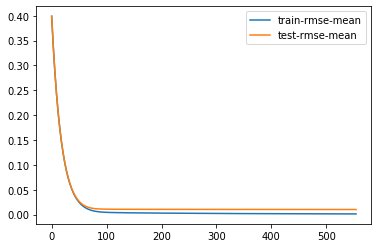

In [344]:
params = {'learning_rate':learning_rate, 'max_depth':max_depth, 'colsample_bytree':colsample_bytree, \
          'subsample':subsample, 'reg_alpha':reg_alpha}

result = xgb.cv(dtrain = dmatrix, params = params, nfold = 5, num_boost_round= 1000, \
              early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=192 )

print(result)

result.plot(use_index = True, y = ['train-rmse-mean', 'test-rmse-mean'])

**n_estimators = 550**
## Test Data Predictions


Encoding categorical data using the same encoding used for the training data 

In [330]:
testing = encoder.transform(raw_testing)

In [331]:
regressor = xgb.XGBRegressor(learning_rate = learning_rate, max_depth = max_depth, colsample_bytree = colsample_bytree, 
                             subsample = subsample, n_estimators = 550, reg_alpha= reg_alpha, objective ='reg:squarederror')
regressor.fit(training, y)
pred = regressor.predict(testing)
testing['pred'] = pred
testing.head()

### Optimize Energy Allocation

In [351]:
alloc = [100 for i in range(298)]
for i in range(100, 0, -1):
    alloc.append(i)
    alloc.append(i)
    alloc.append(i)
    alloc.append(i)
alloc = alloc + [0 for i in range(192)]

In [352]:
sortedbypred = testing.sort_values(by=['pred'])

sortedbypred['opt_pred'] = alloc

sortedbypred.sort_index(inplace = True)
sortedbypred.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),pred,opt_pred
0,1007012,0.047779,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267,232.621842,105.193088,64.241392,17.418350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

**Check Constraints**

In [353]:
#galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available
print(sortedbypred[sortedbypred['existence expectancy index'] < 0.7]['opt_pred'].sum())

#no galaxy should be allocated more than 100 zillion DSML or less than 0 zillion DSML
print(sortedbypred['opt_pred'].max(), sortedbypred['opt_pred'].min())

#in total there are 50000 zillion DSML available for allocation
print(sortedbypred['opt_pred'].sum())

6419
100 0
50000


**Save predictions**

In [355]:
submission = pd.DataFrame(sortedbypred, columns = ['pred', 'opt_pred'])
submission.to_csv(directory / 'submission.csv', index = True, index_label = 'index')